In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import argparse
import xml.etree.ElementTree as ET


In [2]:
images_path = "/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/JPEGImages"
annotated_path = "/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/Annotations"



In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def load_annot_from_folder(folder):
    annot=[]
    for filename in os.listdir(folder):
        ann=os.path.join(folder, filename)
        annot.append(ann)
    return annot

['/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/Annotations/000009.xml', '/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/Annotations/000220.xml', '/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/Annotations/002129.xml', '/Users/sagarsudhakara/Documents/CV_Course/Assignment_2/HW2_Data/Annotations/006919.xml']


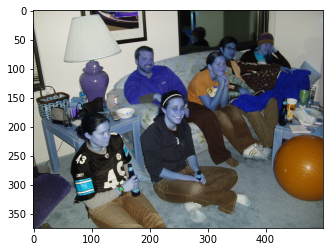

In [4]:
pic = load_images_from_folder(images_path)
annotations=load_annot_from_folder(annotated_path)

print(annotations)
plt.imshow(pic[3])

In [5]:
def get_intersection_area(box1, box2):
    """
    Calculates the intersection area of two bounding boxes where (x1,y1) indicates the top left corner and (x2,y2)
    indicates the bottom right corner
    :param box1: List of coordinates(x1,y1,x2,y2) of box1
    :param box2: List of coordinates(x1,y1,x2,y2) of box2
    :return: float: area of intersection of the two boxes
    """
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])
    # Check for the condition if there is no overlap between the bounding boxes (either height or width
    # of intersection box are negative)
    if (x2 - x1 < 0) or (y2 - y1 < 0):
        return 0.0
    else:
        return (x2 - x1 + 1) * (y2 - y1 + 1)

In [6]:
def calculate_iou(proposal_boxes, gt_boxes):
    """
    Returns the bounding boxes that have Intersection over Union (IOU) > 0.5 with the ground truth boxes
    :param proposal_boxes: List of proposed bounding boxes(x1,y1,x2,y2) where (x1,y1) indicates the top left corner
    and (x2,y2) indicates the bottom right corner of the proposed bounding box
    :param gt_boxes: List of ground truth boxes(x1,y1,x2,y2) where (x1,y1) indicates the top left corner and (x2,y2)
    indicates the bottom right corner of the ground truth box
    :return iou_qualified_boxes: List of all proposed bounding boxes that have IOU > 0.5 with any of the ground
    truth boxes
    :return final_boxes: List of the best proposed bounding box with each of the ground truth box (if available)
    """
    iou_qualified_boxes = []
    final_boxes = []
    for gt_box in gt_boxes:
        best_box_iou = 0
        best_box = 0
        area_gt_box = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
        for prop_box in proposal_boxes:
            area_prop_box = (prop_box[2] - prop_box[0] + 1) * (prop_box[3] - prop_box[1] + 1)
            intersection_area = get_intersection_area(prop_box, gt_box)
            union_area = area_prop_box + area_gt_box - intersection_area
            iou = float(intersection_area) / float(union_area)
            if iou > 0.5:
                iou_qualified_boxes.append(prop_box)
                if iou > best_box_iou:
                    best_box_iou = iou
                    best_box = prop_box
        if best_box_iou != 0:
            final_boxes.append(best_box)
    return iou_qualified_boxes, final_boxes

In [7]:
def get_groundtruth_boxes(annoted_img_path):
    """
    Parses the xml file of the annotated image to obtain the ground truth boxes
    :param annoted_img_path: String: File path of the annotated image containing the ground truth
    :return gt_boxes: List of ground truth boxes(x1,y1,x2,y2) where (x1,y1) indicates the top left corner and (x2,y2)
    indicates the bottom right corner of the ground truth box
    """
    gt_boxes = []
    tree = ET.parse(annoted_img_path)
    root = tree.getroot()
    for items in root.findall('object/bndbox'):
        xmin = items.find('xmin')
        ymin = items.find('ymin')
        xmax = items.find('xmax')
        ymax = items.find('ymax')
        gt_boxes.append([int(xmin.text), int(ymin.text), int(xmax.text), int(ymax.text)])
    return gt_boxes

In [ ]:
if __name__ == "__main__":
    #parser = argparse.ArgumentParser()
    #parser.add_argument("input_image_path", default="./HW2_Data/JPEGImages/000480.jpg", type=str, help="Enter the image path")
    #parser.add_argument("annotated_image_path", default="./HW2_Data/Annotations/000480.xml", type=str, help="Enter the annotated image path")
    #parser.add_argument("strategy", default="color", type=str, help="Enter the strategy - color for color strategy, all for all strategies")
    #args = parser.parse_args()

    #img_path = args.input_image_path
    #annotated_img_path = args.annotated_image_path
    img=pic[3]
    annotated_img_path=annotations[3]
    #img = cv2.imread(img_path)   it is pic[0]
    
    # Download model from https://github.com/opencv/opencv_extra/blob/master/testdata/cv/ximgproc/model.yml.gz
    model_path = "model.yml.gz"
    edge_detection_obj = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    # Convert image from BGR (default color in OpenCV) to RGB
    rgb_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get the edges
    edges = edge_detection_obj.detectEdges(np.float32(rgb_im)/255.0)
    # Create an orientation map
    orient_map = edge_detection_obj.computeOrientation(edges)
    # Suppress edges
    edges = edge_detection_obj.edgesNms(edges, orient_map)
    #cv2.imshow("Edges", edges)
    plt.figure(1)
    plt.imshow(edges)
    #k = cv2.waitKey()
    #cv2.destroyAllWindows()

    #Create edge box:
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(100)
    edge_boxes.setAlpha(0.8)
    edge_boxes.setBeta(0.8)
    prop_boxes, scores = edge_boxes.getBoundingBoxes(edges, orient_map)

    
    # Convert (x,y,w,h) parameters for the top 100 proposal boxes into (x, y, x+w, y+h) parameters
    # to be consistent with the xml tags of the ground truth boxes where (x,y) indicates the
    # top left corner and (x+w,y+h) indicates the bottom right corner of bounding box
    boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in prop_boxes]

    output_img_proposal_top100 = img.copy()
    output_img_iou_qualified = img.copy()
    output_img_final = img.copy()

    # Fetch all ground truth boxes from the annotated image file
    gt_boxes = get_groundtruth_boxes(annotated_img_path)
    print("Number of Ground Truth Boxes = ", len(gt_boxes))

    # Draw bounding boxes for top 100 proposals
    for i in range(0, len(boxes)):
        top_x, top_y, bottom_x, bottom_y = boxes[i]
        cv2.rectangle(output_img_proposal_top100, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 1, cv2.LINE_AA)
    #cv2.imshow("Output_Top_100_Proposals", output_img_proposal_top100)
    plt.figure(2)
    plt.imshow(output_img_proposal_top100)
    cv2.imwrite("./Results1/Output_Top_100_Proposals4a.png", output_img_proposal_top100)
    #cv2.waitKey()
    #cv2.destroyAllWindows()

    # Fetch all proposed bounding boxes that have IOU > 0.5 with the ground truth boxes and also the bounding box
    # that has the maximum/best overlap for each ground truth box
    iou_qualified_boxes, final_boxes = calculate_iou(boxes, gt_boxes)
    print("Number of Qualified Boxes with IOU > 0.5 = ", len(iou_qualified_boxes))
    print("Qualified Boxes = ", iou_qualified_boxes)

    # Draw bounding boxes for iou_qualified_boxes
    for i in range(0, len(iou_qualified_boxes)):
        top_x, top_y, bottom_x, bottom_y = iou_qualified_boxes[i]
        cv2.rectangle(output_img_iou_qualified, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 1, cv2.LINE_AA)
    for i in range(0, len(gt_boxes)):
        top_x, top_y, bottom_x, bottom_y = gt_boxes[i]
        cv2.rectangle(output_img_iou_qualified, (top_x, top_y), (bottom_x, bottom_y), (0, 0, 255), 1, cv2.LINE_AA)
    #cv2.imshow("Output_IOU_Qualified_Proposals", output_img_iou_qualified)
    plt.figure(3)
    plt.imshow(output_img_iou_qualified)
    cv2.imwrite("./Results1/Output_IOU_Qualified_Proposals4a.png", output_img_iou_qualified)
    #cv2.waitKey()
    #cv2.destroyAllWindows()

    print("Number of final boxes = ", len(final_boxes))
    print("Final boxes = ", final_boxes)

    # Recall is calculated as the fraction of ground truth boxes that overlap with at least one proposal box with
    # Intersection over Union (IoU) > 0.5
    recall = len(final_boxes) / len(gt_boxes)
    print("Recall = ", recall)

    # Draw bounding boxes for final_boxes
    for i in range(0, len(final_boxes)):
        top_x, top_y, bottom_x, bottom_y = final_boxes[i]
        cv2.rectangle(output_img_final, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 1, cv2.LINE_AA)
    for i in range(0, len(gt_boxes)):
        top_x, top_y, bottom_x, bottom_y = gt_boxes[i]
        cv2.rectangle(output_img_final, (top_x, top_y), (bottom_x, bottom_y), (0, 0, 255), 1, cv2.LINE_AA)
    #cv2.imshow("Output_Final_Boxes", output_img_final)
    plt.figure(4)
    plt.imshow(output_img_final)
    cv2.imwrite("./Results1/output_img_final4a.png", output_img_final)
    cv2.waitKey()
    cv2.destroyAllWindows()

Number of Ground Truth Boxes =  10
Number of Qualified Boxes with IOU > 0.5 =  51
Qualified Boxes =  [[123, 1, 500, 353], [67, 46, 497, 353], [133, 1, 398, 353], [91, 45, 434, 355], [52, 1, 497, 311], [109, 1, 447, 311], [152, 46, 500, 371], [137, 50, 361, 352], [27, 58, 434, 326], [138, 46, 413, 371], [109, 58, 441, 313], [123, 1, 494, 286], [173, 1, 496, 311], [114, 88, 500, 353], [106, 1, 398, 288], [243, 1, 494, 288], [183, 1, 445, 353], [79, 46, 494, 289], [7, 44, 497, 303], [175, 1, 445, 288], [100, 45, 398, 318], [138, 58, 500, 311], [67, 59, 364, 292], [102, 50, 347, 307], [258, 46, 445, 277], [180, 60, 436, 353], [210, 75, 497, 353], [91, 45, 433, 273], [182, 1, 410, 313], [53, 1, 445, 251], [133, 1, 445, 256], [135, 44, 405, 291], [137, 89, 441, 353], [258, 46, 445, 277], [137, 50, 361, 352], [109, 58, 441, 313], [106, 1, 398, 288], [129, 1, 342, 315], [100, 45, 398, 318], [67, 59, 364, 292], [102, 50, 347, 307], [183, 1, 376, 355], [136, 47, 319, 342], [91, 45, 433, 273], [1